# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 12.01

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [179]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: random_classifier возвращает вероятности пренадлежности объекта классу

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [9]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


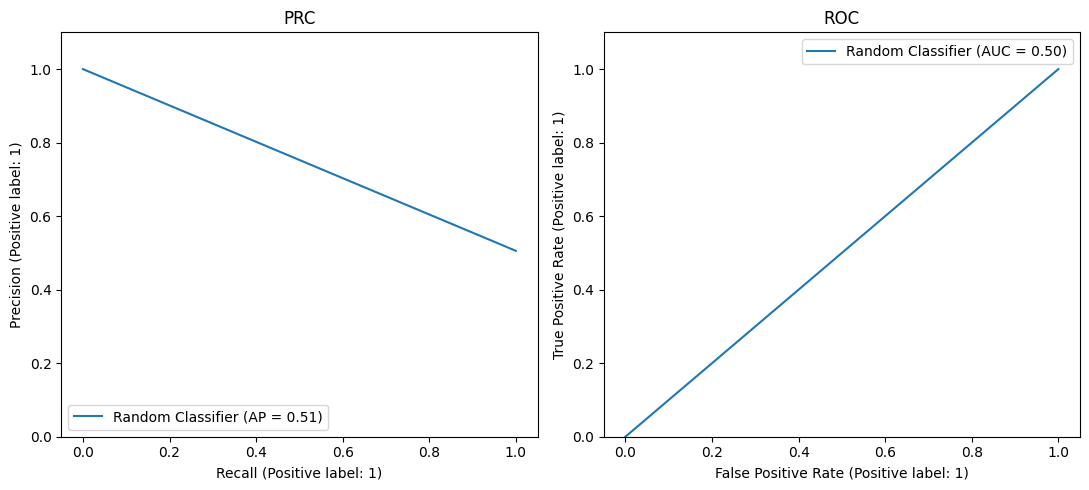

In [19]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name, drawstyle='default')
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [20]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from tqdm import tqdm

Cs = np.logspace(-7, 1, 100)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scores = []

for i, C_ in tqdm(enumerate(Cs)):
    model = SVC(kernel='linear', C = C_)

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='average_precision')

    scores.append(np.mean(cv_scores))

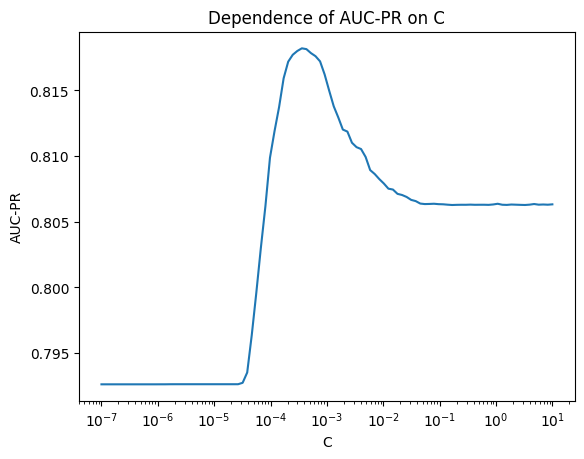

In [23]:
plt.semilogx(Cs, scores)
plt.title('Dependence of AUC-PR on C')
plt.xlabel('C')
plt.ylabel('AUC-PR')
plt.show()

In [24]:
C_svm= Cs[scores.index(max(scores))]
C_svm

0.00035938136638046295

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM Classifier metrics
AUC-PR: 0.82513
AUC-ROC: 0.84332


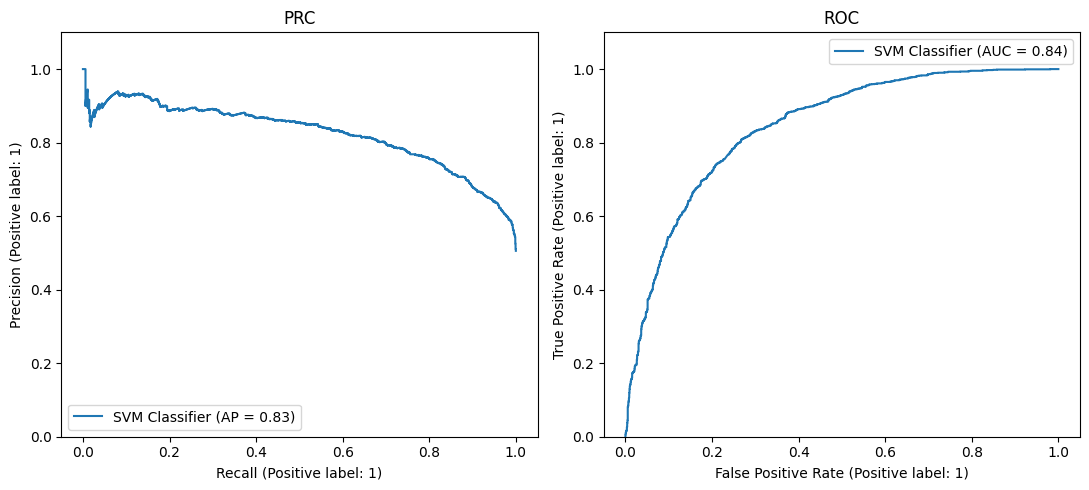

In [25]:
#your code here
def depict_pr_roc(y_true, y_pred, classifier_name='Random Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


model = SVC(kernel='linear', C = C_svm, probability=True)
model.fit(X_train_scaled, y_train)
y_pred_svm = model.predict_proba(X_test_scaled)[:, 1]
depict_pr_roc(y_test, y_pred_svm, classifier_name='SVM Classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [26]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_svm)

df_metrics.loc['SVM Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_svm),
      C_svm
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM Classifier,0.825126,0.843316,0.000359


AUC_PR и AUC_ROC существенно выросли, что говорит о том, что SVM модель гораздо лучше рандомного предсказания

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [11]:
from sklearn.linear_model import LogisticRegression

Cs = np.logspace(-7, 2, 100)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scores = []

for i, C_ in tqdm(enumerate(Cs)):
    model = LogisticRegression(C = C_)
    model.fit(X_train_scaled, y_train)

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='average_precision')

    scores.append(np.mean(cv_scores))

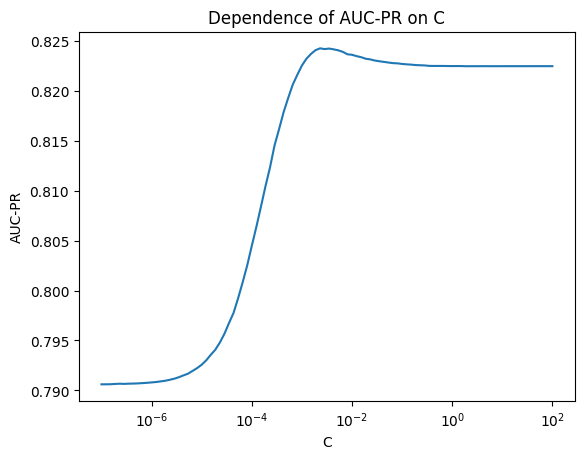

In [28]:
plt.semilogx(Cs, scores)
plt.title('Dependence of AUC-PR on C')
plt.xlabel('C')
plt.ylabel('AUC-PR')
plt.show()

In [29]:
C_logreg= Cs[scores.index(max(scores))]
C_logreg

0.002310129700083158

LogReg Classifier metrics
AUC-PR: 0.83079
AUC-ROC: 0.84557


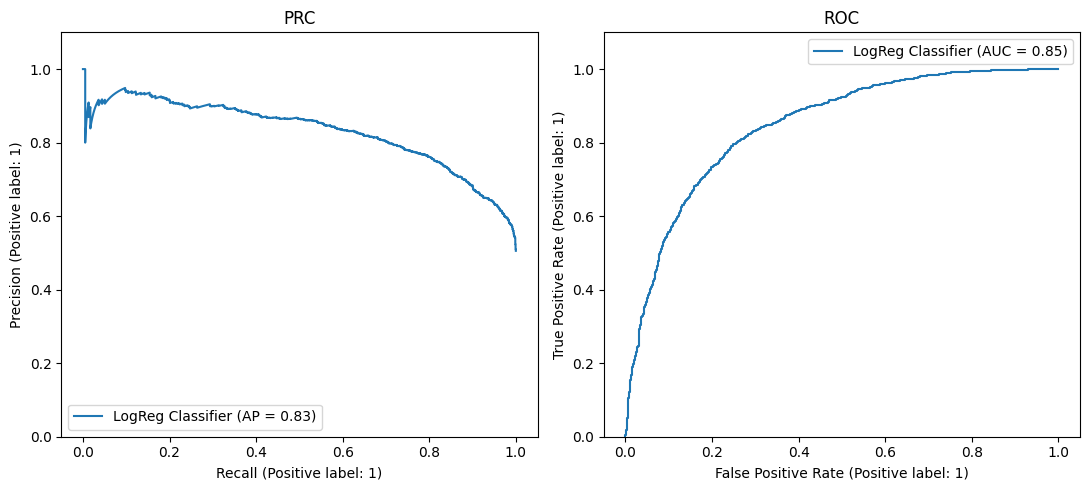

In [30]:
#your code here
def depict_pr_roc(y_true, y_pred, classifier_name='Random Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name, drawstyle='default')
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


model = LogisticRegression(C = C_logreg)
model.fit(X_train_scaled, y_train)
y_pred_logreg = model.predict_proba(X_test_scaled)[:, 1]
depict_pr_roc(y_test, y_pred_logreg, classifier_name='LogReg Classifier')

In [31]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_logreg)

df_metrics.loc['LogReg Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_logreg),
      C_logreg
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM Classifier,0.825126,0.843316,0.000359
LogReg Classifier,0.830791,0.845570,0.002310


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
SVM Classifier metrics
AUC-PR: 0.82513
AUC-ROC: 0.84332
LogReg Classifier metrics
AUC-PR: 0.83079
AUC-ROC: 0.84557


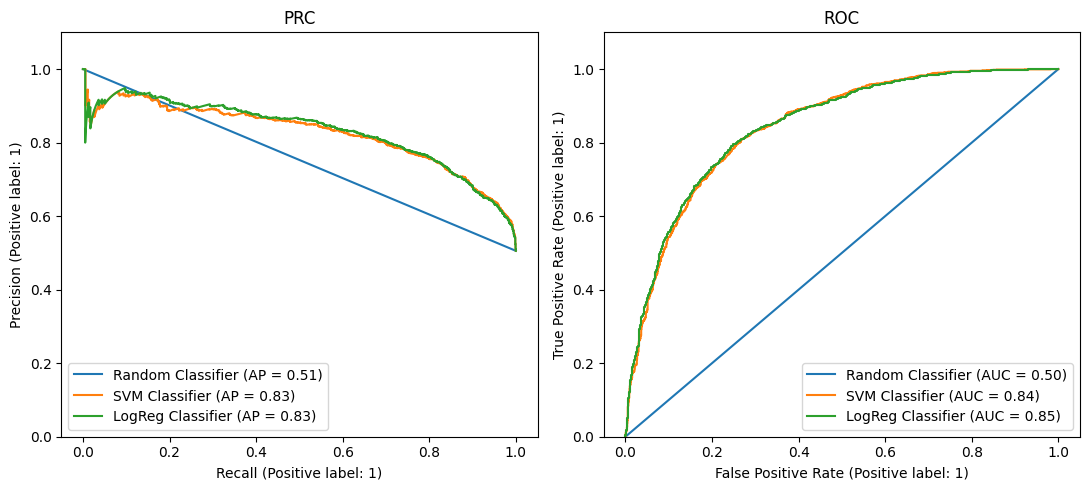

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax = ax)
depict_pr_roc(y_test, y_pred_svm, classifier_name='SVM Classifier', ax = ax)
depict_pr_roc(y_test, y_pred_logreg, classifier_name='LogReg Classifier', ax = ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** LogReg показала на обоих метриках качества немного лучшие результаты, возможно связано с особенностью тестовой выборки

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [39]:
X, y = make_classification(
    n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=44)

In [42]:
model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

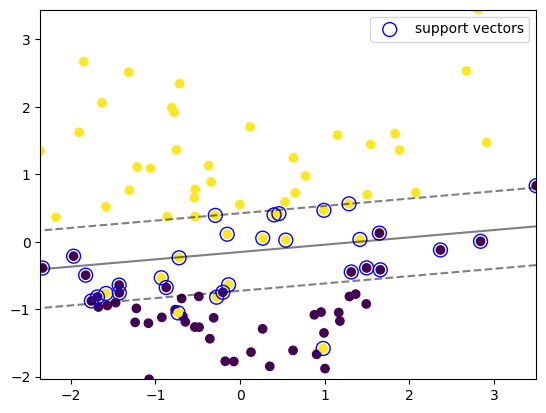

In [43]:
def plot_svm_2D(X, y, model, plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape((len(xx), len(yy)))

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    support_vectors = model.support_vectors_
    
    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** выделяются объекты, лежащие в области предполагаемой моделью граничной прямой. Те объекты, которым сложно однозначно определить класс

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [44]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [45]:
xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

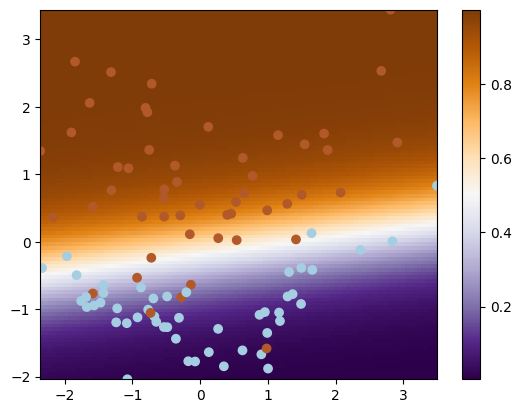

In [46]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Эта область имеет наиболее светлый цвет (по шкале цвет 0.5). Если в этой области модель не уверена, то там находятся такие x, что 

$p(y=+1|x) = p(y=-1|x)$

$p(y=+1|x) + p(y=-1|x) = 1$

а значит $p(y=+1|x) = 0.5$

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [47]:
def plot_calibration_curve(y_test, preds, ax):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    ax.plot(bin_middle_points, bin_real_ratios)
    ax.set_ylim([-0.05, 1.05])
    ax.grid(True)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [89]:
from scipy.special import softmax

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SVC(kernel='linear', C = C_svm, probability=True)
model.fit(X_train_scaled, y_train)
y_pred_svm = model.decision_function(X_test_scaled)
y_pred_svm -= min(y_pred_svm)
y_pred_svm /= max(y_pred_svm)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))
model = LogisticRegression(C = C_logreg)
model.fit(X_train_scaled, y_train)
y_pred_logreg = model.decision_function(X_test_scaled)
y_pred_logreg = sigmoid(y_pred_logreg)

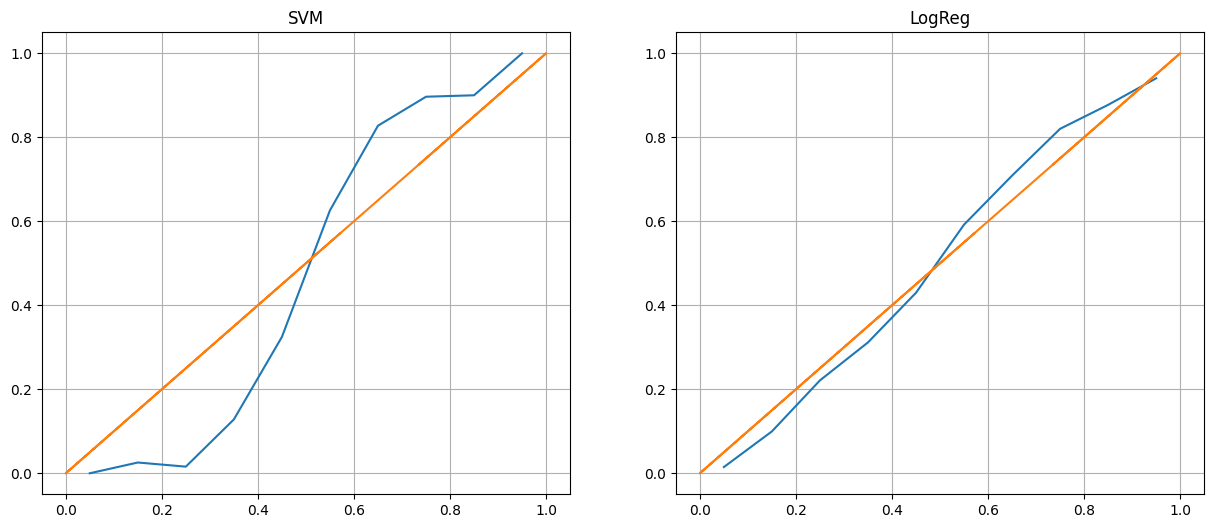

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_calibration_curve(y_test, y_pred_svm, ax[0])
plot_calibration_curve(y_test, y_pred_logreg, ax[1])
ax[0].plot(y_pred_svm, y_pred_svm, label = 'diag')
ax[1].plot(y_pred_svm, y_pred_svm, label = 'diag')

ax[0].set_title('SVM')
ax[1].set_title('LogReg')
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Для LogReg хорошо, но потому что применение сигмоиды корректно конверлируем логиты в вероятности

Для SVM min-max шкалирование как видим из графика плохо калибрует вероятности

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

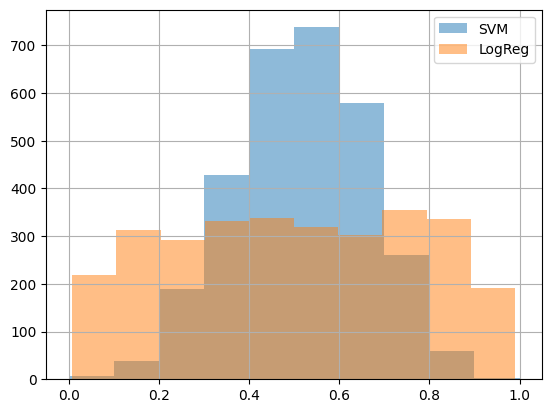

In [91]:
plt.hist(y_pred_svm, alpha = 0.5, label = 'SVM')
plt.hist(y_pred_logreg, alpha = 0.5, label= 'LogReg')
plt.legend()
plt.grid()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У LogReg распределение предсказаний близко к равномерному, а у SVM к нормальному

Веротно потому, что распределение логитов у SVM сосредоточено у нуля, у LogReg такого нет

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

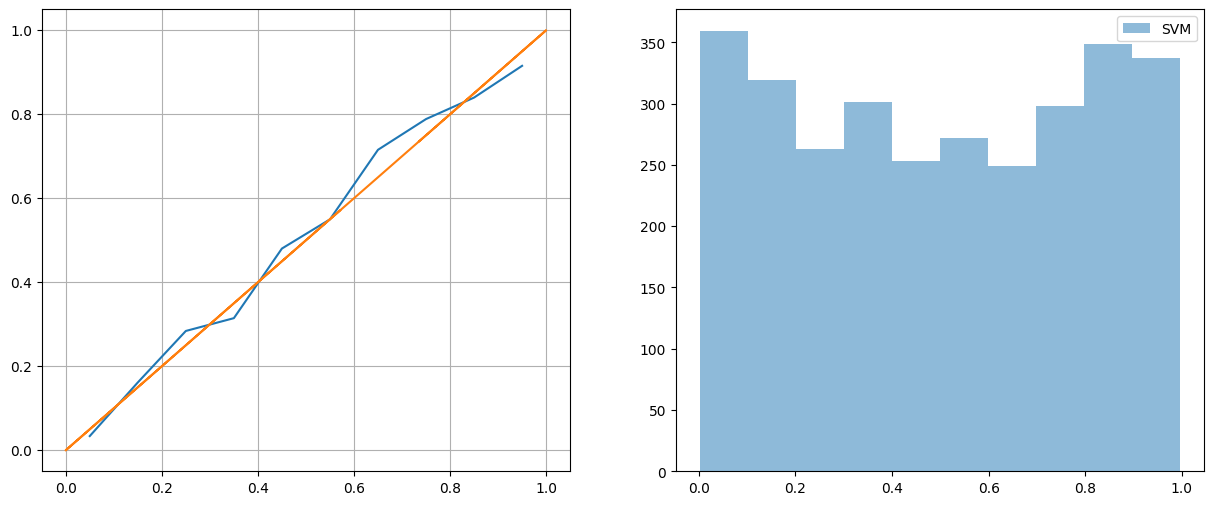

In [92]:
#your code here
from sklearn.calibration import CalibratedClassifierCV

model = SVC(kernel='linear', C = C_svm, probability=True)
calibrated_model = CalibratedClassifierCV(estimator = model)
calibrated_model.fit(X_train, y_train)
y_pred_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_calibration_curve(y_test, y_pred_calibrated, ax = axes[0])
axes[0].plot(y_pred_svm, y_pred_svm, label = 'diag')

axes[1].hist(y_pred_calibrated, alpha = 0.5, label= 'SVM')
plt.legend()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Да, при этом гистограмма стала тоже сильно равномернее

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [120]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import norm

class CalibratingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.y = None
        self.probs = None

    def fit(self, y_true, y_logits):
        self.y = np.linspace(min(y_logits), max(y_logits), 100)
        self.probs = np.zeros(len(self.y)-1)
        for i in range(len(self.y)-1):
            l = self.y[i]
            r = self.y[i+1]
            num_of_true = 0
            num_of_logits = 0
            for j, (true, logit) in enumerate(zip(y_true, y_logits)):
                if logit>=l and logit<=r:
                    num_of_logits+=1
                    if true:
                        num_of_true+=1
            if num_of_logits ==0:
                self.probs[i] = 0
            else:
                self.probs[i] = num_of_true/num_of_logits

    def transform(self, y_logits):
        y_prob = []
        for logit in y_logits:
            for i in range(len(self.y)-1):
                l = self.y[i]
                r = self.y[i+1]
                if logit>=l and logit<=r:
                    y_prob.append(self.probs[i])
                    break
        return np.array(y_prob)

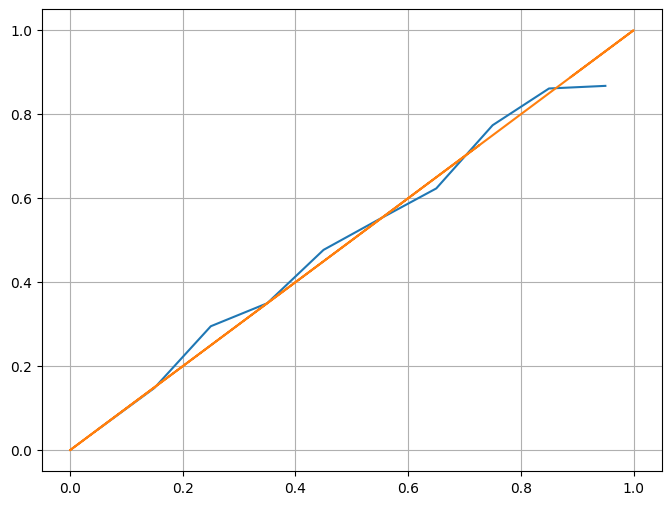

In [122]:
model = SVC(kernel='linear', C = C_svm, probability=True)
model.fit(X_train, y_train)

calibrator = CalibratingTransformer()
calibrator.fit(y_train, model.decision_function(X_train))

y_pred = model.decision_function(X_test)
y_pred = calibrator.transform(y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
plot_calibration_curve(y_test, y_pred, ax = ax)
ax.plot(y_pred, y_pred, label = 'diag')
plt.show()

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [123]:
df = pd.read_csv('bike_buyers.csv')

In [124]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных
types = pd.DataFrame(df.dtypes)
columns_cat = list(types[types[0]=='object'].index)
# columns_num = list(types[(types[0] == 'int64') | (types[0] == 'float64')].index)
df[columns_cat] = df[columns_cat].fillna("undefined")
# df[columns_num] = df[columns_num].fillna(0)

X = df.drop(columns=['ID', 'Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X.loc[:, [
    'Income', 
    'Children', 
    'Cars', 
    'Age']]

X_categorical = X.loc[:, [
    'Marital Status',
    'Gender',
    'Education',
    'Occupation',
    'Home Owner',
    'Commute Distance',
    'Region']]

В начале поработаем только с категориальными признаками

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [128]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

encoder = OrdinalEncoder()

X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)


y_pred = model.predict_proba(X_test_scaled)[:, 1]


precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.57964


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [133]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

model = LogisticRegression()
model.fit(X_train_enc, y_train)


y_pred = model.predict_proba(X_test_enc)[:, 1]


precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.66186


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [134]:
from collections import defaultdict
dct = defaultdict(lambda: defaultdict(float))
dct

for feature in X_train.columns:
    for value in set(X_train[feature]):
        indexes = X_train.index[X_train[feature] == value].tolist()
        mean = np.mean(y_train[indexes])
        dct[feature][value] = mean

In [137]:
X_train_mt = X_train.copy()
X_test_mt = X_test.copy()

for feature in X_train.columns:
    X_train_mt[feature] = X_train[feature].map(dct[feature])
    X_test_mt[feature] = X_test[feature].map(dct[feature])

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_mt)
X_test_scaled = scaler.transform(X_test_mt)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict_proba(X_test_scaled)[:, 1]


precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.67423


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [244]:
#your code here
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import norm

class MeanTargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target, features, noise = 0, C = 0):
        self.target = target
        self.features = features
        self.dct = defaultdict(lambda: defaultdict(float))
        self.noise = noise
        self.C = C

    def fit(self, X, y):
        for feature in self.features:
            pair = pd.concat([X[feature], y], axis=1)
            stats_sum = pair.groupby(feature).sum()[self.target]
            stats_count = pair.groupby(feature).count()[self.target]

            stats_sum += self.C*np.mean(y)
            stats_mean = stats_sum/stats_count
            stats_mean*=(1 + norm.rvs(size = len(stats_mean), scale = self.noise, loc = 0))
            self.dct[feature]=stats_mean.to_dict()
        return self

    def transform(self, X):
        X_t = X.copy()

        for feature in X_train.columns:
            X_t[feature] = X_t[feature].map(self.dct[feature])

        return X_t

In [139]:
mt_transformer = MeanTargetTransformer('Purchased Bike', list(X_categorical.columns))

X_train_mt = mt_transformer.fit_transform(X_train, y_train)
X_test_mt = mt_transformer.transform(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_mt)
X_test_scaled = scaler.transform(X_test_mt)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)


y_pred = model.predict_proba(X_test_scaled)[:, 1]


precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.67423


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [161]:
mt_transformer = MeanTargetTransformer('Purchased Bike', list(X_categorical.columns), noise=0.0001)

score = 0
for i in range(100):
    X_train_mt = mt_transformer.fit_transform(X_train, y_train)
    X_test_mt = mt_transformer.transform(X_test)

    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train_mt)
    X_test_scaled = scaler.transform(X_test_mt)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)


    y_pred = model.predict_proba(X_test_scaled)[:, 1]


    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    score += auc(recall, precision)

score/=100
print('mean AUC-PR: %.5f' % score)

mean AUC-PR: 0.67426


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Позапускав с разными значениями шума, качество почти не улучшалось. Видимо данных слишком мало чтобы бороться с переобучением шумом

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [336]:
# попробуем вычислять mean-target по фолдам (2 способ)
from sklearn.model_selection import KFold

dct = defaultdict(lambda: defaultdict(float))
num_of_folds = 8
kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=500)

X_train_mt = X_train.copy()
X_test_mt = X_test.copy()

for feature in X_train.columns:
    for rest_index, fold_index in kf.split(X_train):
        X_rest, X_fold = X_train.iloc[rest_index], X_train.iloc[fold_index]
        y_rest, y_fold = y_train.iloc[rest_index], y_train.iloc[fold_index]
        index = X_rest.index
        for value in set(X_fold[feature]):
            indexes = X_rest.index[X_rest[feature] == value].tolist()
            mean = np.mean(y_rest[indexes])*(1 + norm.rvs(scale = 0.001, loc = 0))
            X_train_mt.loc[index, feature] = mean
            dct[feature][value] += mean/num_of_folds

for feature in X_train.columns:
    X_test_mt[feature] = X_test[feature].map(dct[feature])

X_test_mt = X_test_mt.fillna(np.mean(y_train))
X_train_mt = X_train_mt.fillna(np.mean(y_train))

In [337]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_mt)
X_test_scaled = scaler.transform(X_test_mt)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict_proba(X_test_scaled)[:, 1]


precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.63088


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


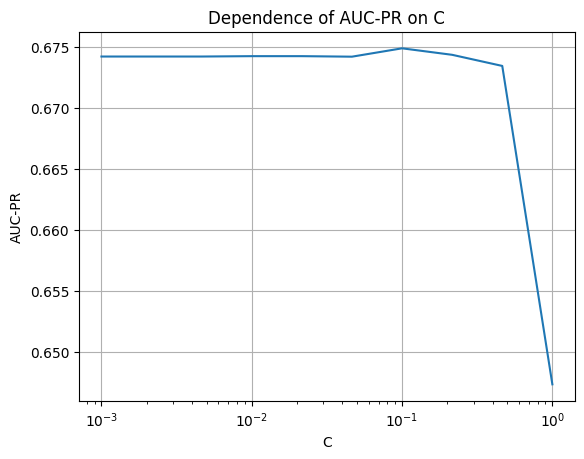

In [340]:
Cs = np.logspace(-3, 0, 10)
scores = []

for C_ in Cs:
    mt_transformer = MeanTargetTransformer('Purchased Bike', list(X_categorical.columns), C = C_)

    X_train_mt = mt_transformer.fit_transform(X_train, y_train)
    X_test_mt = mt_transformer.transform(X_test)

    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train_mt)
    X_test_scaled = scaler.transform(X_test_mt)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)


    y_pred = model.predict_proba(X_test_scaled)[:, 1]


    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    scores.append(auc(recall, precision))

plt.semilogx(Cs, scores)
plt.title('Dependence of AUC-PR on C')
plt.xlabel('C')
plt.ylabel('AUC-PR')
plt.grid()
plt.show()

In [345]:
best_C = Cs[scores.index(max(scores))]
print('best C:', best_C)
print('AUC-PR: %.5f' % max(scores))

best C: 0.1
AUC-PR: 0.67487


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [346]:
X[X.columns[X.dtypes != 'object']] = X[X.columns[X.dtypes != 'object']].fillna(X_numerical.mean())

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [356]:
for feature in X_numerical.columns:
    print(feature, "- unique :", len(set(X_numerical[feature])))

Income - unique : 22
Children - unique : 14
Cars - unique : 14
Age - unique : 61


In [357]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Попробуем закодировать вместе

In [359]:
mt_transformer = MeanTargetTransformer('Purchased Bike', list(X.columns))

X_train_mt = mt_transformer.fit_transform(X_train, y_train)
X_test_mt = mt_transformer.transform(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_mt)
X_test_scaled = scaler.transform(X_test_mt)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)


y_pred = model.predict_proba(X_test_scaled)[:, 1]


precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.69109


Попробуем по отдельности

In [368]:
for feature in X_numerical.columns:
    mt_transformer = MeanTargetTransformer('Purchased Bike', list(X_categorical.columns) + [feature])
    print('Encoded:', feature)
    
    X_train_mt = mt_transformer.fit_transform(X_train, y_train)
    X_test_mt = mt_transformer.transform(X_test)

    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train_mt)
    X_test_scaled = scaler.transform(X_test_mt)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)


    y_pred = model.predict_proba(X_test_scaled)[:, 1]


    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    print('AUC-PR: %.5f' % auc(recall, precision))

Encoded: Income
AUC-PR: 0.71742
Encoded: Children
AUC-PR: 0.68743
Encoded: Cars
AUC-PR: 0.68902
Encoded: Age
AUC-PR: 0.64569


Стало заметно лучше

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ #your answer here

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [371]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

25226.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
--2023-11-21 20:10:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data»

adult.data              [          <=>       ]   3,79M   448KB/s    за 13s     

2023-11-21 20:10:34 (306 KB/s) - «adult.data» сохранён [3974305]



In [5]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
X = df.drop(columns=['income'])
y = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
31484,31,Private,225779,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,<=50K


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [7]:
categorical = list(X.columns[X.dtypes == 'object'])
numeric = list(X.columns[X.dtypes != 'object'])

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

num_of_cat0 = len(categorical)

ohe = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

X_cat_train_encoded = ohe.fit_transform(X_train[categorical])
X_cat_test_encoded = ohe.transform(X_test[categorical])

X_num_train_scaled = scaler.fit_transform(X_train[numeric])
X_num_test_scaled = scaler.transform(X_test[numeric])

X_train_ = np.concatenate([X_cat_train_encoded, X_num_train_scaled], axis=1)
X_test_ = np.concatenate([X_cat_test_encoded, X_num_test_scaled], axis=1)

num_of_cat1 = X_cat_train_encoded.shape[1]

print('Число новых признаков:', num_of_cat1 - num_of_cat0)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [241]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_, y_train)
y_pred =  model.predict_proba(X_test_)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.76713


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [245]:
class TopFeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, weights, n):
        self.weights = weights
        self.n = n

    def fit(self, X, y):
        self.important_inds = self.weights.argsort()[-self.n:][::-1]
        return self

    def transform(self, X):
        return X[:, self.important_inds]

In [246]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)

logreg_model = pipeline.named_steps['regression']
coefficients = logreg_model.coef_[0]


pipeline_ = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('feature_selector', TopFeaturesSelector(coefficients, 40)),
    ('regression', LogisticRegression(max_iter=1000))
])

model = pipeline_.fit(X_train, y_train)
y_pred =  model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

features_selector = pipeline_.named_steps['feature_selector']
features_indexes = features_selector.important_inds

AUC-PR: 0.76402


Изменилось ли качество? Как?

Несмотря на то, что мы выбросили часть признаков, качество немного ухудшилось, ведь мы стали учитывать не всю информацию, но зато такая модель с большей обобщающей способностью.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

Выше я делал на масштабированных, сделаем на неотмасштабированных, заметим что качество стало заметно хуже

In [247]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)

logreg_model = pipeline.named_steps['regression']
coefficients = logreg_model.coef_[0]


pipeline_ = Pipeline(steps=[
    ('ohe', column_transformer),
    ('feature_selector', TopFeaturesSelector(coefficients, 40)),
    ('regression', LogisticRegression(max_iter=1000))
])

model = pipeline_.fit(X_train, y_train)
y_pred =  model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.68174


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [248]:
ohe = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

X_cat_train_encoded = ohe.fit_transform(X_train[categorical])
X_cat_test_encoded = ohe.transform(X_test[categorical])

X_train_ = np.concatenate([X_cat_train_encoded, X_train[numeric]], axis=1)
X_test_ = np.concatenate([X_cat_test_encoded, X_test[numeric]], axis=1)

X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_, y_train)
coefficients = model.coef_[0]

important_inds = coefficients.argsort()[-40:][::-1]
X_train_ = X_train_[:, important_inds]
X_test_ = X_test_[:, important_inds]

model = LogisticRegression(max_iter=1000)
model.fit(X_train_, y_train)
y_pred =  model.predict_proba(X_test_)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.76466


Отмасштабировав и OHE переменные, качество удалось еще немного поднять

In [249]:
print('Different features:', *set(features_indexes).difference(important_inds))

Different features: 33 98 101 12 13


Список отобранных features тоже немного изменился

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [250]:
ohe = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

X_cat_train_encoded = ohe.fit_transform(X_train[categorical])
X_cat_test_encoded = ohe.transform(X_test[categorical])

X_train_ = np.concatenate([X_cat_train_encoded, X_train[numeric]], axis=1)
X_test_ = np.concatenate([X_cat_test_encoded, X_test[numeric]], axis=1)

X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)

In [251]:
features = np.arange(X_train_.shape[1])

t = np.zeros(len(features))

for feature in features:
    pos_mask = (y_train==1).astype(int).values
    neg_mask = (y_train==0).astype(int).values
    mu_pos = np.mean(pos_mask*X_train_[:, feature])
    mu_neg = np.mean(neg_mask*X_train_[:, feature])
    n_pos = np.sum(pos_mask)
    n_neg = np.sum(neg_mask)
    sigma_pos = np.std(pos_mask*X_train_[:, feature])
    sigma_neg = np.std(neg_mask*X_train_[:, feature])
    
    t[feature] = np.abs(mu_pos - mu_neg)/np.sqrt((n_pos*sigma_pos**2 + n_neg*sigma_neg**2)/(n_pos + n_neg))

top_features = t.argsort()[-40:][::-1]

In [252]:
X_train_ = X_train_[:, top_features]
X_test_ = X_test_[:, top_features]

model = LogisticRegression(max_iter=1000)
model.fit(X_train_, y_train)
y_pred =  model.predict_proba(X_test_)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.76199


При таком отборе признаков, качество немного упало

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [48]:
ohe = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

X_cat_train_encoded = ohe.fit_transform(X_train[categorical])
X_cat_val_encoded = ohe.transform(X_val[categorical])
X_cat_test_encoded = ohe.transform(X_test[categorical])

X_train_ = np.concatenate([X_cat_train_encoded, X_train[numeric]], axis=1)
X_val_ = np.concatenate([X_cat_val_encoded, X_val[numeric]], axis=1)
X_test_ = np.concatenate([X_cat_test_encoded, X_test[numeric]], axis=1)

X_train_ = scaler.fit_transform(X_train_)
X_val_ = scaler.transform(X_val_)
X_test_ = scaler.transform(X_test_)


num_of_features = X_train_.shape[1]


while num_of_features > 40:
    scores = []
    for feature in tqdm(range(num_of_features)):

        X_train_del = np.delete(X_train_, feature, axis=1)
        X_val_del = np.delete(X_val_, feature, axis=1)

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_del, y_train)

        y_pred =  model.predict_proba(X_val_del)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        scores.append(auc(recall, precision))

    ind = scores.index(np.max(scores))
    X_train_ = np.delete(X_train_, ind, axis=1)
    X_val_ = np.delete(X_val_, ind, axis=1)
    X_test_ = np.delete(X_test_, ind, axis=1)
    num_of_features-=1
    print(np.max(scores))


100%|██████████| 108/108 [01:05<00:00,  1.64it/s]


0.7664453429845093


100%|██████████| 107/107 [01:15<00:00,  1.43it/s]


0.7666161884045093


100%|██████████| 106/106 [01:34<00:00,  1.12it/s]


0.7669332350182744


100%|██████████| 105/105 [01:30<00:00,  1.16it/s]


0.7670679801197007


100%|██████████| 104/104 [00:48<00:00,  2.16it/s]


0.7671404701483324


100%|██████████| 103/103 [00:46<00:00,  2.19it/s]


0.7672327200193142


100%|██████████| 102/102 [00:34<00:00,  2.95it/s]


0.7672594232912097


100%|██████████| 101/101 [00:39<00:00,  2.59it/s]


0.7679025690684946


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


0.7686293598799122


100%|██████████| 99/99 [00:30<00:00,  3.25it/s]


0.7687914465929944


100%|██████████| 98/98 [00:31<00:00,  3.15it/s]


0.7690241156038593


100%|██████████| 97/97 [00:30<00:00,  3.20it/s]


0.7692968975957699


100%|██████████| 96/96 [00:30<00:00,  3.10it/s]


0.7694708590858385


100%|██████████| 95/95 [00:30<00:00,  3.15it/s]


0.7696382802506435


100%|██████████| 94/94 [00:30<00:00,  3.03it/s]


0.7697192596509391


100%|██████████| 93/93 [00:29<00:00,  3.20it/s]


0.7698155296346835


100%|██████████| 92/92 [00:29<00:00,  3.14it/s]


0.7699048585716105


100%|██████████| 91/91 [00:28<00:00,  3.17it/s]


0.7699814053503821


100%|██████████| 90/90 [00:28<00:00,  3.18it/s]


0.7700306954229272


100%|██████████| 89/89 [00:28<00:00,  3.14it/s]


0.7700753776197007


100%|██████████| 88/88 [00:27<00:00,  3.20it/s]


0.7701232656377179


100%|██████████| 87/87 [00:24<00:00,  3.51it/s]


0.770146554318478


100%|██████████| 86/86 [00:23<00:00,  3.69it/s]


0.7701813748742224


100%|██████████| 85/85 [00:23<00:00,  3.63it/s]


0.770222551268817


100%|██████████| 84/84 [00:22<00:00,  3.71it/s]


0.7702507515596365


100%|██████████| 83/83 [00:22<00:00,  3.62it/s]


0.7703069073766429


100%|██████████| 82/82 [00:25<00:00,  3.19it/s]


0.7703249237731072


100%|██████████| 81/81 [00:22<00:00,  3.59it/s]


0.7703436620289641


100%|██████████| 80/80 [00:21<00:00,  3.70it/s]


0.7703491210222793


100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


0.7704897329869104


100%|██████████| 78/78 [00:28<00:00,  2.77it/s]


0.7709985139955022


100%|██████████| 77/77 [00:19<00:00,  3.98it/s]


0.7710130351566767


100%|██████████| 76/76 [00:19<00:00,  3.95it/s]


0.7710145198413589


100%|██████████| 75/75 [00:22<00:00,  3.39it/s]


0.7710967568280048


100%|██████████| 74/74 [00:18<00:00,  4.08it/s]


0.7711023753631908


100%|██████████| 73/73 [00:18<00:00,  3.90it/s]


0.7711277958487794


100%|██████████| 72/72 [00:17<00:00,  4.10it/s]


0.7711453637588785


100%|██████████| 71/71 [00:17<00:00,  4.15it/s]


0.7711477981020364


100%|██████████| 70/70 [00:16<00:00,  4.21it/s]


0.7711502083104977


100%|██████████| 69/69 [00:15<00:00,  4.40it/s]


0.7712809700311108


100%|██████████| 68/68 [00:15<00:00,  4.48it/s]


0.7712859207805873


100%|██████████| 67/67 [00:13<00:00,  4.81it/s]


0.7712885560635572


100%|██████████| 66/66 [00:15<00:00,  4.18it/s]


0.7712825849160425


100%|██████████| 65/65 [00:14<00:00,  4.52it/s]


0.7712942942760602


100%|██████████| 64/64 [00:13<00:00,  4.60it/s]


0.771289180368847


100%|██████████| 63/63 [00:12<00:00,  4.89it/s]


0.7712929973070595


100%|██████████| 62/62 [00:13<00:00,  4.66it/s]


0.7712864434996146


100%|██████████| 61/61 [00:13<00:00,  4.55it/s]


0.7712809554847012


100%|██████████| 60/60 [00:12<00:00,  4.80it/s]


0.7712741825435551


100%|██████████| 59/59 [00:12<00:00,  4.84it/s]


0.7712550949127752


100%|██████████| 58/58 [00:12<00:00,  4.78it/s]


0.771233846194694


100%|██████████| 57/57 [00:11<00:00,  4.90it/s]


0.7712079622132649


100%|██████████| 56/56 [00:11<00:00,  4.82it/s]


0.7711834910629984


100%|██████████| 55/55 [00:11<00:00,  4.90it/s]


0.7711540264415624


100%|██████████| 54/54 [00:11<00:00,  4.75it/s]


0.7711220288278615


100%|██████████| 53/53 [00:08<00:00,  6.05it/s]


0.7710767711901362


100%|██████████| 52/52 [00:08<00:00,  5.98it/s]


0.7710483936643329


100%|██████████| 51/51 [00:08<00:00,  6.29it/s]


0.7709632960738918


100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


0.7708689558031802


100%|██████████| 49/49 [00:07<00:00,  6.99it/s]


0.77078268065683


100%|██████████| 48/48 [00:06<00:00,  7.21it/s]


0.7706719262931542


100%|██████████| 47/47 [00:06<00:00,  7.21it/s]


0.7705468015387228


100%|██████████| 46/46 [00:06<00:00,  7.11it/s]


0.7703675762585483


100%|██████████| 45/45 [00:06<00:00,  7.22it/s]


0.7703040118613207


100%|██████████| 44/44 [00:06<00:00,  7.32it/s]


0.7701929140179052


100%|██████████| 43/43 [00:05<00:00,  7.44it/s]


0.7700169833194033


100%|██████████| 42/42 [00:05<00:00,  7.76it/s]


0.7697333448375329


100%|██████████| 41/41 [00:05<00:00,  7.67it/s]

0.7694533899648934


Такой отбор призаков занял у меня 26m 41.7s, посчитаем качество на тестовой выборке:

In [49]:
X_train_ = np.concatenate([X_train_, X_val_], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0)

In [50]:
ohe = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_, y_train)

y_pred =  model.predict_proba(X_test_)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)

print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.77108


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [38]:
ohe = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

X_cat_train_encoded = ohe.fit_transform(X_train[categorical])
X_cat_val_encoded = ohe.transform(X_val[categorical])
X_cat_test_encoded = ohe.transform(X_test[categorical])

X_train_ = np.concatenate([X_cat_train_encoded, X_train[numeric]], axis=1)
X_val_ = np.concatenate([X_cat_val_encoded, X_val[numeric]], axis=1)
X_test_ = np.concatenate([X_cat_test_encoded, X_test[numeric]], axis=1)

X_train_ = scaler.fit_transform(X_train_)
X_val_ = scaler.transform(X_val_)
X_test_ = scaler.transform(X_test_)


available_features = set(np.arange(X_train_.shape[1]))
num_of_features = 0

X_train_acc = np.zeros((X_train_.shape[0], 1))
X_val_acc = np.zeros((X_val_.shape[0], 1))
X_test_acc = np.zeros((X_val_.shape[0], 1))


while num_of_features < 40:
    scores = [0]*X_train_.shape[1]
    for feature in tqdm(available_features):

        X_train_add = np.hstack((X_train_acc, X_train_[:, feature].reshape((-1, 1))))
        X_val_add = np.hstack((X_val_acc, X_val_[:, feature].reshape((-1, 1))))

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_add, y_train)

        y_pred =  model.predict_proba(X_val_add)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        scores[feature] = auc(recall, precision)

    ind = scores.index(np.max(scores))
    X_train_acc = np.hstack((X_train_acc, X_train_[:, ind].reshape((-1, 1))))
    X_val_acc = np.hstack((X_val_acc, X_val_[:, ind].reshape((-1, 1))))
    X_test_acc = np.hstack((X_test_acc, X_test_[:, ind].reshape((-1, 1))))
    num_of_features+=1
    available_features.remove(ind)
    print(np.max(scores))

100%|██████████| 108/108 [00:03<00:00, 33.86it/s]


0.6690030088231873


100%|██████████| 107/107 [00:03<00:00, 34.29it/s]


0.672373000366228


100%|██████████| 106/106 [00:03<00:00, 34.12it/s]


0.6760694389685888


100%|██████████| 105/105 [00:03<00:00, 32.03it/s]


0.6790060352176113


100%|██████████| 104/104 [00:05<00:00, 18.36it/s]


0.6815795805447047


100%|██████████| 103/103 [00:09<00:00, 10.70it/s]


0.6836278737188801


100%|██████████| 102/102 [00:08<00:00, 11.61it/s]


0.6854601546443922


100%|██████████| 101/101 [00:03<00:00, 25.33it/s]


0.6871597676975623


100%|██████████| 100/100 [00:03<00:00, 25.89it/s]


0.6885790891403046


100%|██████████| 99/99 [00:03<00:00, 24.82it/s]


0.6900374515148562


100%|██████████| 98/98 [00:03<00:00, 29.22it/s]


0.6912789037564985


100%|██████████| 97/97 [00:04<00:00, 24.17it/s]


0.6923898624482228


100%|██████████| 96/96 [00:05<00:00, 17.01it/s]


0.6933577979387736


100%|██████████| 95/95 [00:04<00:00, 20.04it/s]


0.6944022079290268


100%|██████████| 94/94 [00:04<00:00, 22.63it/s]


0.6955316415594403


100%|██████████| 93/93 [00:04<00:00, 22.28it/s]


0.6960858546382526


100%|██████████| 92/92 [00:04<00:00, 21.29it/s]


0.6964381045207026


100%|██████████| 91/91 [00:04<00:00, 19.15it/s]


0.6967658624056078


100%|██████████| 90/90 [00:04<00:00, 21.28it/s]


0.6976832017187905


100%|██████████| 89/89 [00:04<00:00, 18.25it/s]


0.7100237502363712


100%|██████████| 88/88 [00:05<00:00, 15.86it/s]


0.7309864237793252


100%|██████████| 87/87 [00:06<00:00, 12.50it/s]


0.7394030256441878


100%|██████████| 86/86 [00:05<00:00, 15.23it/s]


0.7463732188647616


100%|██████████| 85/85 [00:06<00:00, 14.01it/s]


0.7512693183347342


100%|██████████| 84/84 [00:06<00:00, 12.54it/s]


0.7551030544431314


100%|██████████| 83/83 [00:07<00:00, 11.84it/s]


0.7582552350692244


100%|██████████| 82/82 [00:06<00:00, 12.51it/s]


0.7599554508110713


100%|██████████| 81/81 [00:06<00:00, 12.43it/s]


0.7610964381060872


100%|██████████| 80/80 [00:06<00:00, 11.90it/s]


0.762378233702703


100%|██████████| 79/79 [00:07<00:00, 11.21it/s]


0.7634594221259282


100%|██████████| 78/78 [00:06<00:00, 12.16it/s]


0.7643158039422084


100%|██████████| 77/77 [00:07<00:00, 10.88it/s]


0.765251681164923


100%|██████████| 76/76 [00:07<00:00, 10.26it/s]


0.7661132122900918


100%|██████████| 75/75 [00:07<00:00, 10.14it/s]


0.7669355052774149


100%|██████████| 74/74 [00:07<00:00,  9.95it/s]


0.7674672777650898


100%|██████████| 73/73 [00:07<00:00,  9.96it/s]


0.7679970776155517


100%|██████████| 72/72 [00:07<00:00,  9.43it/s]


0.7685031326112708


100%|██████████| 71/71 [00:08<00:00,  8.87it/s]


0.7688748267810723


100%|██████████| 70/70 [00:08<00:00,  8.59it/s]


0.7692242341480736


100%|██████████| 69/69 [00:08<00:00,  8.35it/s]

0.769570788330335


Такой поиск отработал гораздо быстрее, за 4 минуты, посчитаем качество на тестовой выборке:

Во всемя набора features не наступил момент, когда качество ухудшилось

In [43]:
y_train.shape

(24420,)

In [44]:
X_train_ = np.concatenate([X_train_acc, X_val_acc], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0)
X_test_ = X_test_acc

In [45]:
ohe = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_, y_train)

y_pred =  model.predict_proba(X_test_)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)

print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.77180


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Оба метода позволили улучшить модель, по сравнению с набором признаков разом

При этом первый поиск работал очень долго, а второй дал даже то же качество за гораздо меньшее время

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [144]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [145]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [146]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [147]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [148]:
categorical = list(X.columns[X.dtypes == object])
numeric = list(X.columns[X.dtypes != object])

In [149]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

answers = []
predictions = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index].values.astype(float), y[test_index].values.astype(float)

    answers.append(y_test)

    model = pipeline.fit(X_train, y_train)
    y_pred =  model.predict(X_test)
    predictions.append(y_pred)

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [150]:
revenues = []
salaries = []

for i in range(len(answers)):
    revenue = np.sum(answers[i]*predictions[i])*10
    revenues.append(revenue)
    salary = np.sum(predictions[i])
    salaries.append(salary)

print('средняя выручка =', np.mean(np.array(revenues)))
print('средняя зарплата оператора =', np.mean(np.array(salaries)))
print('средняя прибыль =', np.mean(np.array(revenues)) - np.mean(np.array(salaries)))

средняя выручка = 2130.0
средняя зарплата оператора = 324.2
средняя прибыль = 1805.8


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [151]:
from scipy.stats import uniform

revenues = []
salaries = []

for i in range(len(answers)):
    agreed = round(np.sum(answers[i]*predictions[i]))
    variables = uniform.rvs(size = agreed, loc = 0, scale = 20)
    revenues.append(np.sum(variables))
    salary = np.sum(predictions[i])
    salaries.append(salary)

print('средняя выручка =', np.mean(np.array(revenues)))
print('средняя зарплата оператора =', np.mean(np.array(salaries)))
print('средняя прибыль =', np.mean(np.array(revenues)) - np.mean(np.array(salaries)))

средняя выручка = 2155.9596198060353
средняя зарплата оператора = 324.2
средняя прибыль = 1831.7596198060353


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [42]:
from sklearn.metrics import make_scorer

Cs = np.logspace(-5, 1, 10)

def profit(y_test, y_pred):
    agreed = round(np.sum(y_test*y_pred))
    variables = uniform.rvs(size = agreed, loc = 0, scale = 20)
    salary = np.sum(y_pred)
    return sum(variables) - salary


scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False)

scaled_columns  = scaler.fit_transform(X[numeric]) 
encoded_columns = ohe.fit_transform(X[categorical])

X_ = np.concatenate([scaled_columns, encoded_columns], axis=1)

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, {'C': Cs}, cv=kf, scoring=make_scorer(profit, greater_is_better=True))
grid_search.fit(X_, y)
print(grid_search.best_params_)

{'C': 2.154434690031882}


In [70]:
scores = []

for i in range(5):
    scores.append(list(grid_search.cv_results_[f'split{i}_test_score']))
scores = np.array(scores).T
sigmas = np.std(scores, axis=1)

In [71]:
print('наилучшее значение прибыли:', grid_search.best_score_)

наилучшее значение прибыли: 1869.4921343968883


получилось немного увеличить прибыль

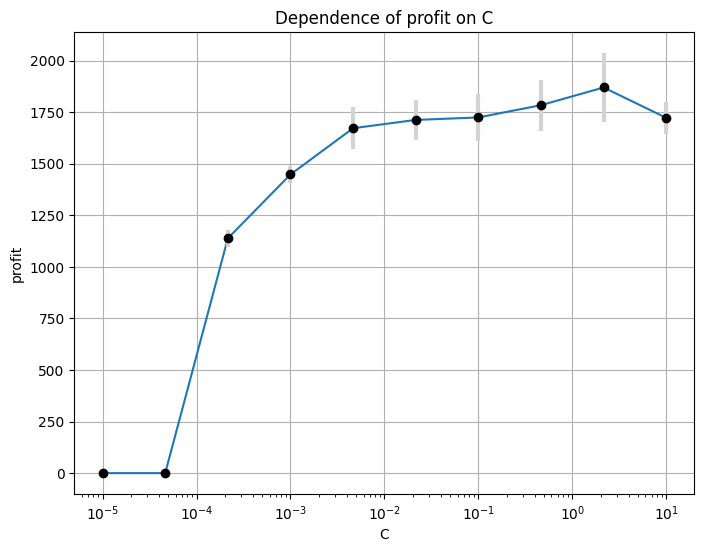

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(Cs, grid_search.cv_results_['mean_test_score'])

ax.errorbar(Cs, grid_search.cv_results_['mean_test_score'], yerr=sigmas, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
ax.set_xscale('log')
ax.set_title('Dependence of profit on C')
ax.set_xlabel('C')
ax.set_ylabel('profit')
ax.grid()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [41]:
Cs = np.logspace(-5, 1, 10)

def profit(y_test, y_pred):
    agreed = round(np.sum(y_test*y_pred))
    variables = uniform.rvs(size = agreed, loc = 0, scale = 20)
    salary = np.sum(y_pred)
    return sum(variables) - salary


scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False)

scaled_columns  = scaler.fit_transform(X[numeric]) 
encoded_columns = ohe.fit_transform(X[categorical])

X_ = np.concatenate([scaled_columns, encoded_columns], axis=1)

for i in range(10):
    model = LogisticRegression(max_iter=1000)
    grid_search = GridSearchCV(model, {'C': Cs}, cv=kf, scoring=make_scorer(profit, greater_is_better=True))
    grid_search.fit(X_, y)
    print('запуск:', i)
    print('наилучший параметр:', grid_search.best_params_)
    print('наилучшее значение прибыли:', grid_search.best_score_)

запуск: 0
наилучший параметр: {'C': 0.1}
наилучшее значение прибыли: 1849.8479916742358
запуск: 1
наилучший параметр: {'C': 10.0}
наилучшее значение прибыли: 1812.9606958944041
запуск: 2
наилучший параметр: {'C': 0.1}
наилучшее значение прибыли: 1843.5283405800578
запуск: 3
наилучший параметр: {'C': 10.0}
наилучшее значение прибыли: 1806.6195695760457
запуск: 4
наилучший параметр: {'C': 10.0}
наилучшее значение прибыли: 1848.765120797579
запуск: 5
наилучший параметр: {'C': 2.154434690031882}
наилучшее значение прибыли: 1816.6643382008165
запуск: 6
наилучший параметр: {'C': 0.46415888336127725}
наилучшее значение прибыли: 1813.8542726016753
запуск: 7
наилучший параметр: {'C': 0.46415888336127725}
наилучшее значение прибыли: 1818.636896098205
запуск: 8
наилучший параметр: {'C': 0.46415888336127725}
наилучшее значение прибыли: 1834.9514466291675
запуск: 9
наилучший параметр: {'C': 2.154434690031882}
наилучшее значение прибыли: 1843.855906957388


Закономерность не наблюдается, выбирается произвольный С, значит не существует лучшего коэфициента для такой модели со случайным функционалом качества

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ В данной задаче нам стоит повышать recall, то есть покрыть звонками всех клиентов которые согласятся. От если будем максимизировать precision, то можно получить 20 рублей за одного верно угаданного клиента, тогда precision = 1, но это не то что нам нужно.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [169]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

answers = []
predictions = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index].values.astype(float), y[test_index].values.astype(float)

    answers.append(y_test)


    model = pipeline.fit(X_train, y_train)
    y_pred =  model.predict_proba(X_test)[:, 1]
    predictions.append(y_pred)

In [75]:
threshold = np.linspace(0, 1, 101)

best_t = 0
profits = []
sigmas = []

for t in threshold:
    sum_profit = 0
    prediction = (predictions[i] > t).astype(int)
    answer = answers[i]
    profits_ = []
    for k in range(5):
        profits_.append(profit(prediction, answer))

    profits.append(np.mean(profits_))
    sigmas.append(np.std(profits_))

In [101]:
print('best threshold:', best_threshold := threshold[profits.index(max(profits))])
print('best profit:', max(profits))

best threshold: 0.0
best profit: 8806.211534155782


Так как выбрался нимимальный threshold, значит правда нужно максимизировать recall

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




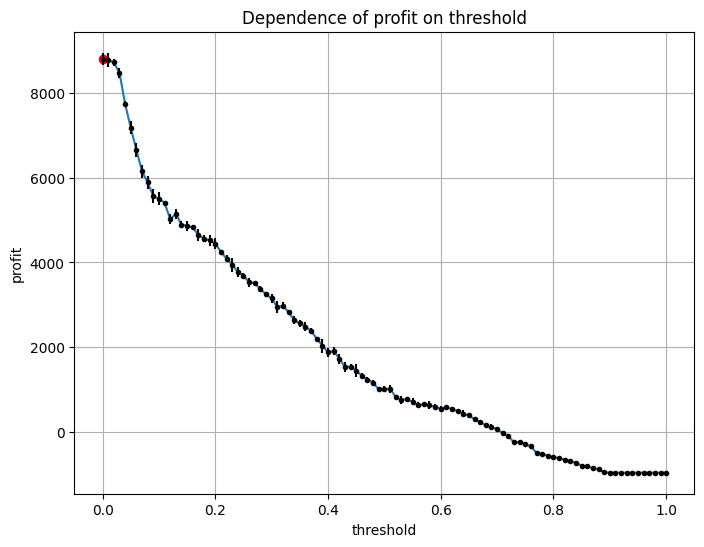

In [92]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(threshold, profits)
ax.scatter(threshold[profits.index(max(profits))], max(profits), marker='o', c = 'r')
ax.errorbar(threshold, profits, yerr=sigmas, fmt='.k')

ax.set_title('Dependence of profit on threshold')
ax.set_xlabel('threshold')
ax.set_ylabel('profit')
ax.grid()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [100]:
print('Доля людей в выборке, которые согласны внести депозит:', np.mean(y.values.astype(int)), '> 0.1')

Доля людей в выборке, которые согласны внести депозит: 0.11265417111780131 > 0.1


__Ответ:__ Порог всегда получается в области 0, так как звонок клиенту стоит 1, в среднем клиент приносит 10, значит если доля клиентов которые принесут деньги не меньше 0.1, то это выигрышная стратегия

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [111]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

answers = []
predictions = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index].values.astype(float), y[test_index].values.astype(float)

    answers.append(y_test)

    model = pipeline.fit(X_train, y_train)
    y_pred =  model.predict_proba(X_test)[:, 1]
    predictions.append(y_pred)

for i in range(len(predictions)):
    predictions[i] = (predictions[i]>best_threshold).astype(int)

In [140]:
TP = [np.sum(predictions[i]*answers[i]) for i in range(5)]
FN = np.sum(answers[i]) - TP
TN = [np.sum((1-predictions[i])*(1-answers[i])) for i in range(5)]
FP = np.sum((1-answers[i])) - TN

precisions = [TP[i]/(TP[i]+FP[i]) for i in range(5)]
recalls = [TP[i]/(TP[i]+FN[i]) for i in range(5)]

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

sigma_precision = np.std(precisions)
sigma_recall = np.std(recalls)

In [142]:
print('средний precision:', mean_precision, 'std:', sigma_precision)
print('средний recall:', mean_recall, 'std:', sigma_recall)

средний precision: 0.11324260047830632 std: 0.003124027357643157
средний recall: 0.9557157569515962 std: 0.029713020723976632


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [214]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

y_true = y_test.astype(int)

model = pipeline.fit(X_train, y_train)
y_pred =  model.predict_proba(X_test)[:, 1]

AUC-PR: 0.44552


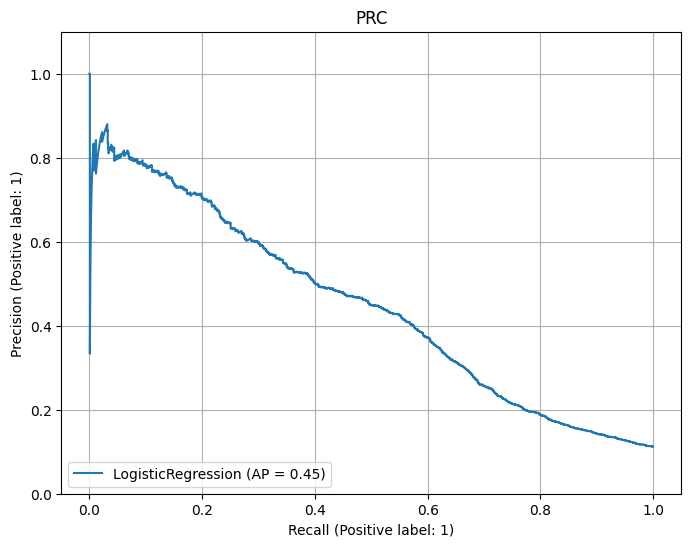

In [215]:
fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax, name='LogisticRegression', drawstyle='default')
precision, recall, _ = precision_recall_curve(y_true, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC")
ax.set_ylim(0, 1.1)
ax.grid()
plt.show()

Выберем нужный квадрат:

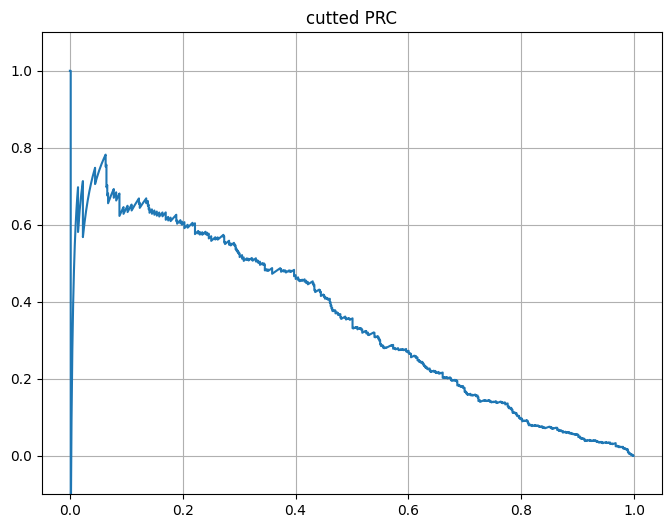

In [232]:
fig, ax = plt.subplots(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_true, y_pred)
precision, recall = precision[::-1], recall[::-1]
ind = None
for i in range(len(precision)):
    if recall[i]>=0.5:
        ind = i
        break

precision, recall = precision[:ind], recall[:ind]
precision-=precision[-1]
precision/= np.max(precision)
recall*=2

ax.plot(recall, precision)
ax.set_title("сutted PRC")
ax.set_ylim(-0.1, 1.1)
ax.grid()
plt.show()

In [235]:
print('Cutted AUC-PR: %.5f' % auc(recall, precision))

Cutted AUC-PR: 0.35252


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ ничего(